In [208]:
import numpy as np
import pandas as pd
import re
import keras
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from navec import Navec
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time

### 1) Предобработка датасета

In [209]:
dataset = pd.read_excel("./data/dataset_200.xls", index_col=None)
dataset

,Toxic comment,Polite comment
0,"почитай посты у этого автора, дебил.","попробуйте почитать посты этого автора, может ..."
1,"мне жаль тебя, гандон, если для тебя оскорблен...","извините, но мне вас очень жаль, если для вас ..."
2,"тебе в говне ходить нормально, урод?","извини, но приятно бы тебе было ходить в грязном?"
3,"блять, я согласен, что энергия от виэ на текущ...","я согласен с вами, что энергия от виэ на текущ..."
4,я этим сраным ватсаппом никогда не пользовался...,"просто я, к сожалению, ватсаппом никогда не по..."
...,...,...
194,Пошел нахуй с тупичка,Уходите с тупичка
195,"Да уж, ебаные татары русское население мягко г...","Да уж, татары русское население мягко говоря н..."
196,Умный дурак в два раза опасней,Умный глупец в два раза опасней
197,Это беседа одного того самого имбецила?,Это беседа одного того самого человека?


In [210]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Toxic comment   199 non-null    object
 1   Polite comment  199 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [211]:
dataset.describe()

,Toxic comment,Polite comment
count,199,199
unique,199,199
top,"почитай посты у этого автора, дебил.","попробуйте почитать посты этого автора, может ..."
freq,1,1


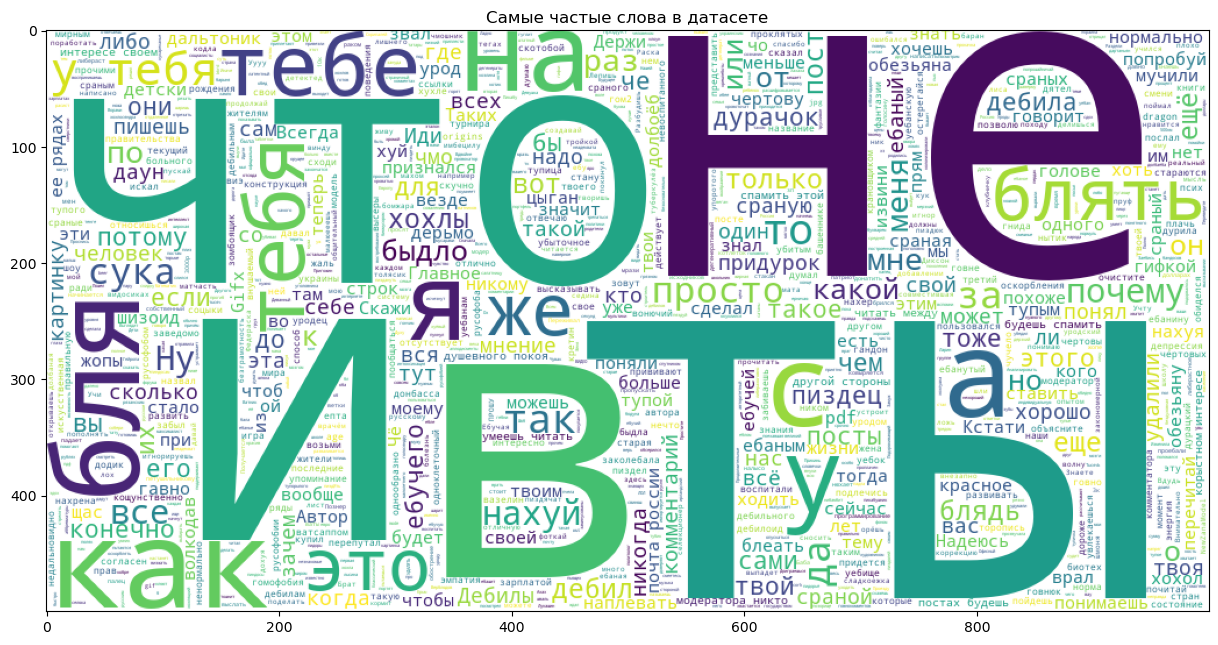

In [212]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(dataset["Toxic comment"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

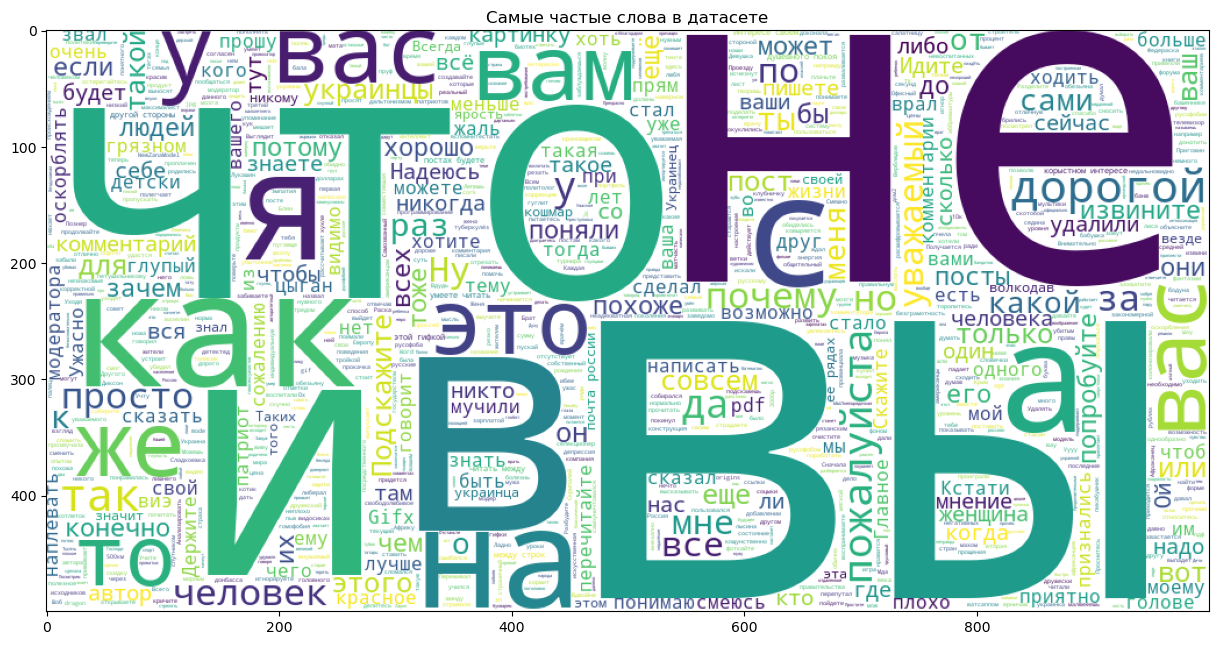

In [213]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(dataset["Polite comment"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

### 2) Токенизация

In [214]:
dataset["Toxic comment"] = dataset["Toxic comment"].apply(lambda text: word_tokenize(text))
dataset["Toxic comment"] = dataset["Toxic comment"].apply(lambda sequence: " ".join(sequence))

dataset["Polite comment"] = dataset["Polite comment"].apply(lambda text: word_tokenize(text))
dataset["Polite comment"] = dataset["Polite comment"].apply(lambda sequence: ["<start>"] + sequence + ["<end>"])
dataset["Polite comment"] = dataset["Polite comment"].apply(lambda sequence: " ".join(sequence))

texts = dataset["Toxic comment"].tolist() + dataset["Polite comment"].tolist()
texts[:5]

['почитай посты у этого автора , дебил .',
 'мне жаль тебя , гандон , если для тебя оскорбления - норма .',
 'тебе в говне ходить нормально , урод ?',
 'блять , я согласен , что энергия от виэ на текущий момент дороже . но объясните мне , нахуя правительства всех стран мира стараются развить эту ебанину ? ! нахрена развивать нечто , заведомо убыточное ? !',
 'я этим сраным ватсаппом никогда не пользовался , а теперь придется ставить ради одного дебильного турнира . пиздец']

In [215]:
tokenizer = Tokenizer(filters = '', lower=True, split=" ", char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

In [216]:
vocab_size = len(tokenizer.index_word)
vocab_size #число уникальный слов

1316

In [217]:
encoded_toxic = tokenizer.texts_to_sequences(dataset["Toxic comment"])
encoded_polite = tokenizer.texts_to_sequences(dataset["Polite comment"])

In [218]:
lengths = []
for doc in encoded_toxic + encoded_polite:
    lengths.append(len(doc))
max_lengths = max(lengths)
max_lengths

39

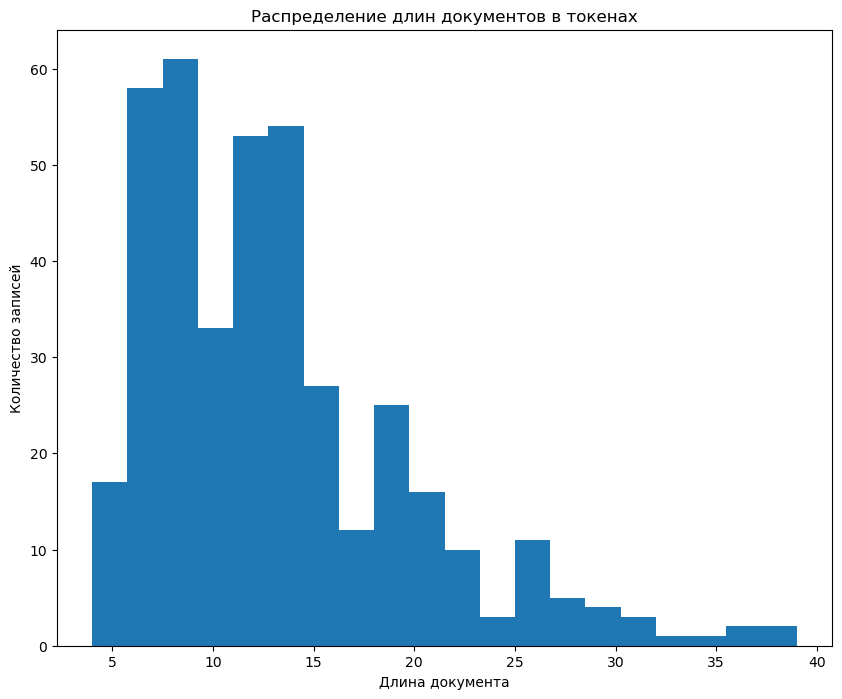

In [219]:
plt.figure(figsize=(10,8))
plt.hist(lengths, bins=20)
plt.title("Распределение длин документов в токенах")
plt.xlabel("Длина документа")
plt.ylabel("Количество записей")
plt.show()

In [220]:
padded_toxic = pad_sequences(encoded_toxic, maxlen=max_lengths, padding="post", truncating="post", value=0)
padded_polite = pad_sequences(encoded_polite, maxlen=max_lengths, padding="post", truncating="post", value=0)

padded_polite

array([[   4,  197, 1134, ...,    0,    0,    0],
       [   4,  198,    2, ...,    0,    0,    0],
       [   4,  216,    2, ...,    0,    0,    0],
       ...,
       [   4,  844, 1314, ...,    0,    0,    0],
       [   4,   23,  848, ...,    0,    0,    0],
       [   4,   27,    8, ...,    0,    0,    0]])

In [221]:
tokenizer.index_word[0] = "<pad>" 
tokenizer.word_index["<pad>"] = 0
vocab_size += 1

In [222]:
target_data = np.zeros(shape=(len(dataset), max_lengths, vocab_size), dtype=float)
for d, doc_tokenized in enumerate(padded_polite):
    for t, word_id in enumerate(doc_tokenized[1:]):
        if word_id > 0:
            target_data[d][t][word_id] = 1

In [223]:
target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

### 3) Эмбеддинги

In [224]:
navec = Navec.load("./embeddings/navec_hudlit_v1_12B_500K_300d_100q.tar")

In [225]:
embedding_matrix = np.zeros((vocab_size, 300))

for i in range(1, vocab_size):
    word = tokenizer.index_word[i]
    if navec.get(word) is not None:
        embedding_matrix[i] = navec.get(word)

### 4) Обучение модели

In [226]:
encoder_input = Input(shape=(max_lengths,), dtype=float)
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=300)(encoder_input)
encoder_output, encoder_hidden_state, encoder_context = LSTM(units=256, return_state=True)(encoder_embedding)
encoder_state = [encoder_hidden_state, encoder_context]

decoder_input = Input(shape=(max_lengths,), dtype=float)
decoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=300)
decoder_embedding = decoder_embedding_layer(decoder_input)
decoder_lstm_layer = LSTM(units=256, return_sequences=True, return_state=True)
decoder_lstm, _, _ = decoder_lstm_layer(decoder_embedding, initial_state=encoder_state)
decoder_dense = Dense(units=vocab_size, activation="softmax")
decoder_output = decoder_dense(decoder_lstm)

model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 39)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 39)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 39, 300)              395100    ['input_11[0][0]']            
                                                                                                  
 embedding_9 (Embedding)     (None, 39, 300)              395100    ['input_12[0][0]']            
                                                                                           

In [227]:
model.layers[2].set_weights([embedding_matrix])
model.layers[3].set_weights([embedding_matrix])

In [228]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [229]:
history = model.fit(x=[padded_toxic, padded_polite], y=target_data, validation_data=None, validation_split=0, epochs=200, batch_size=10, verbose=1)

Epoch 1/200
20/20 [==============================] - 10s 198ms/step - loss: 2.1643
Epoch 2/200
20/20 [==============================] - 4s 209ms/step - loss: 1.9299
Epoch 3/200
20/20 [==============================] - 4s 214ms/step - loss: 1.8925
Epoch 4/200
20/20 [==============================] - 4s 214ms/step - loss: 1.8707
Epoch 5/200
20/20 [==============================] - 4s 204ms/step - loss: 1.8582
Epoch 6/200
20/20 [==============================] - 5s 240ms/step - loss: 1.8427
Epoch 7/200
20/20 [==============================] - 4s 221ms/step - loss: 1.8344
Epoch 8/200
20/20 [==============================] - 4s 174ms/step - loss: 1.8253
Epoch 9/200
20/20 [==============================] - 3s 149ms/step - loss: 1.8157
Epoch 10/200
20/20 [==============================] - 5s 258ms/step - loss: 1.8077
Epoch 11/200
20/20 [==============================] - 4s 176ms/step - loss: 1.8001
Epoch 12/200
20/20 [==============================] - 3s 164ms/step - loss: 1.7936
Epoch 13/200

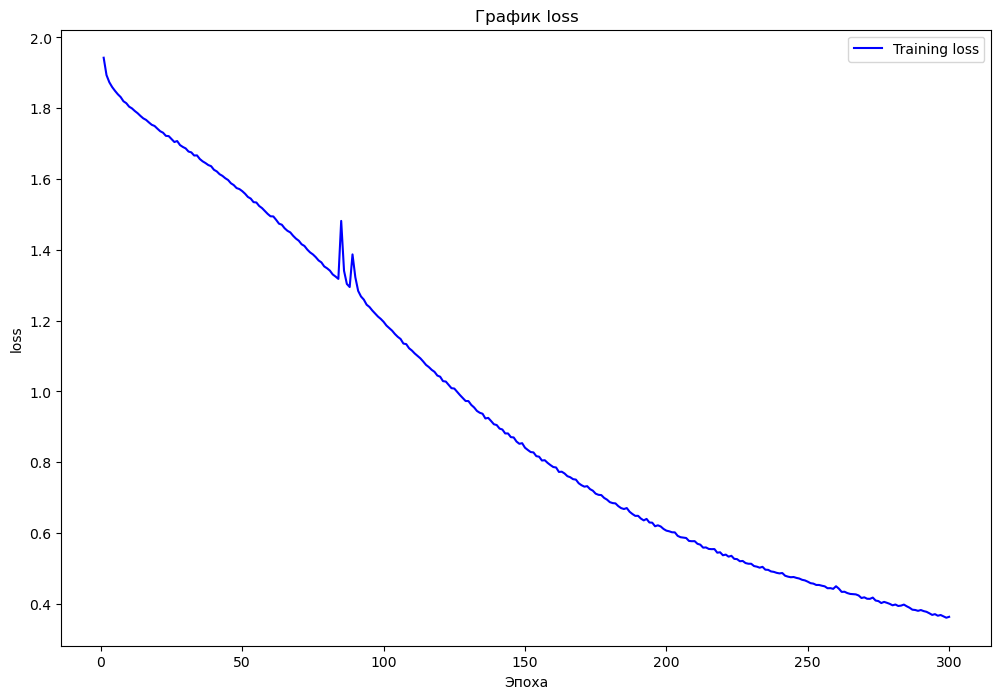

In [230]:
plt.figure(figsize=(12,8))
epochs = range(1, len(history_dict['loss']) + 1)
plt.plot(epochs, history_dict["loss"], 'b', label='Training loss')
plt.title("График loss")
plt.xlabel('Эпоха')
plt.ylabel('loss')
plt.legend()
plt.show()

### 5) Как работает модель

#### Энкодер

In [231]:
encoder_input = model.input[0]

encoder_embedding = model.layers[2](encoder_input)
encoder_output, *encoder_state = model.layers[4](encoder_embedding)

encoder_model = Model(inputs=encoder_input, outputs=encoder_state)

#### Декодер

In [232]:
decoder_input = model.input[1]

decoder_hidden_state = Input(shape=(256,))
decoder_context = Input(shape=(256,))
decoder_state_input = [decoder_hidden_state, decoder_context]

decoder_embedding = model.layers[3](decoder_input)

decoder_lstm, *decoder_state = model.layers[5](decoder_embedding, initial_state=decoder_state_input)

decodet_output = model.layers[6](decoder_lstm)

decoder_model = Model(inputs=[decoder_input] + decoder_state_input, outputs=[decodet_output] + decoder_state)

In [233]:
decoder_model.layers

#### Детоксикация текста

In [234]:
def decode_sequence(input_seq) -> str:
    state = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index["<start>"]

    stop_condition = False
    decoded_sentence = ""
    decoded_counter = 0
    while not stop_condition:
        output_tokens, *state = decoder_model.predict([target_seq] + state)

        pred_token = np.argmax(output_tokens[0, -1, :])
        pred_word = tokenizer.index_word[pred_token]
        target_seq[0, 0] = pred_token

        if pred_word in ["<end>", "<pad>"] or decoded_counter >= max_lengths:
            stop_condition = True
        else:
            decoded_sentence += f" {pred_word}"
            decoded_counter += 1

    decoded_sentence = re.sub(r'\s+(?=(?:[,.?!:;…]))', r'', decoded_sentence)
    return decoded_sentence.strip()

In [237]:
text = "почитай посты у этого автора, дебил."
print(text)

sequence = word_tokenize(text)
text = " ".join(sequence)
encoded_text = tokenizer.texts_to_sequences([text])
padded_text = pad_sequences(encoded_text, maxlen=max_lengths, padding="post", truncating="post", value=0) 

decoded_sentence = decode_sequence(padded_text)
print(decoded_sentence)

почитай посты у этого автора, дебил.
1/1 [==============================] - 0s 36ms/step
вы, дорогой, просто не умеете читать между строк.


In [238]:
for token in padded_text[0]:
    print(f"{token} — {tokenizer.index_word[token]}")

871 — почитай
60 — посты
13 — у
56 — этого
256 — автора
2 — ,
105 — дебил
3 — .
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
